# Paclitaxel BRCA Samples

In [ ]:
# Set the working directory to the location of CYTOi EMC data files for Paclitaxel BRCA analysis
source('../..//functions.R')
setwd('../../CYTOi/Paclitaxel/Expression_Mutation_CNA')

In [ ]:
#dir.create("Results", showWarnings = FALSE)
#dir.create('Graphs',showWarnings = FALSE)

In [2]:
#---------------------------------------------------------------------------------------------------------------
# Read and process sensitive CYTOi Paclitaxel BRCA sample data (expression, mutation, CNA)

#dir.create("Results", showWarnings = FALSE)
#process_tsv_files('TCGA - EMC CYTOi Paclitaxel Resistant BRCA Samples CNA.tsv','TCGA - EMC CYTOi Paclitaxel Resistant BRCA Samples Gene Expression.tsv')


# Process gene symbol conversion table
conversion_table <- data.frame(
        Old.Symbol = c("CCN1", "DSC3", "CELSR1", "DSP", "RIN2", "TCF4"),
        Converted.Symbol = c("PPP3CA", "DSC2", "ME2", "DSPP", "RASSF4", "TCF7L2")
)

# Process Paclitaxel BRCA data for sensitive and resistant samples
CYTOi_Paclitaxel_BRCA = process_drug_data(
        expr_sensitive_file = 'TCGA - EMC CYTOi Paclitaxel Sensitive BRCA Samples Gene Expression.tsv',
        cna_sensitive_file = 'TCGA - EMC CYTOi Paclitaxel Sensitive BRCA Samples CNA.tsv',
        expr_resistant_file = 'TCGA - EMC CYTOi Paclitaxel Resistant BRCA Samples Gene Expression.tsv',
        cna_resistant_file = 'TCGA - EMC CYTOi Paclitaxel Resistant BRCA Samples CNA.tsv',
        mut_sensitive_file = 'TCGA - EMC CYTOi Paclitaxel Sensitive BRCA Samples Mutation.tsv',
        mut_resistant_file = 'TCGA - EMC CYTOi Paclitaxel Resistant BRCA Samples Mutation.tsv',
        conversion_table = conversion_table
)

# Assign condition factor levels
CYTOi_Paclitaxel_BRCA$condition = factor(CYTOi_Paclitaxel_BRCA$condition, levels = c('resistant','sensitive'))

#---------------------------------------------------------------------------------------------------------------
# Clinical Data Processing

# Retrieve clinical data for TCGA-BRCA project
CYTOi_BRCA_Clinical = get_multiple_clinical_data(tcga_project = c('TCGA-BRCA'))

# Find matching samples between processed data and clinical data
sum(rownames(CYTOi_Paclitaxel_BRCA) %in% CYTOi_BRCA_Clinical$submitter_id) # Check the overlap (27 samples)

# Filter clinical data to match the processed samples
CYTOi_BRCA_Clinical_Paclitaxel = CYTOi_BRCA_Clinical %>% filter(submitter_id %in% rownames(CYTOi_Paclitaxel_BRCA))

new_row_indices <- match(rownames(CYTOi_Paclitaxel_BRCA), CYTOi_BRCA_Clinical_Paclitaxel$submitter_id)
CYTOi_BRCA_Clinical_Paclitaxel <- CYTOi_BRCA_Clinical_Paclitaxel[new_row_indices, ]

# Create a survival object using clinical data
CYTOi_BRCA_Paclitaxel_Surv = Surv(
        time = CYTOi_BRCA_Clinical_Paclitaxel$overall_survival,
        event = CYTOi_BRCA_Clinical_Paclitaxel$deceased
)

#saveRDS(CYTOi_BRCA_Paclitaxel_Surv,'Results/CYTOi_BRCA_Paclitaxel_Surv.rds')


[1] 27

### Note on Computation Time
The calculation steps for the Penalized Cox Models and the subsequent Multi-Gene Cox Models are computationally intensive and can take a significant amount of time to run.

For your convenience, you can skip re-running these analyses. The code block below allows you to directly load the pre-computed results (.rds files) to proceed with the analysis and visualization steps immediately

In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Penalized Cox Regression Analysis

# Run penalized Cox regression models
CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel = drug_small_sample_models_cond_penalized_with_pvalue_optimized(
        data = CYTOi_Paclitaxel_BRCA,
        surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
        seed = 73
)

# Load enriched terms and extract unique genes
enrich_terms = read_excel('enriched_terms.xlsx')
gen_list <- extract_unique_genes(enrich_terms)

# Process existing models with the gene list
CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel <- process_models(CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel, gen_list)

# Save the processed Cox models
#saveRDS(CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel, 'Results/CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel.rds')

In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Multi-Gene Cox Models

# Run multi-gene Cox models without combination terms
multiGeneCox_CYTOi_BRCA = drug_multigene_models_cond_penalized(
        CYTOi_Paclitaxel_BRCA,
        CYTOi_BRCA_Paclitaxel_Surv,
        pathway_file = 'enriched_terms.xlsx',
        CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel,
        combination = F,
        seed=91
)

head(multiGeneCox_CYTOi_BRCA$Model_1)

# Save multi-gene Cox model results
#saveRDS(multiGeneCox_CYTOi_BRCA, 'Results/CYTOi_EMC_BRCA_Paclitaxel_MultiGeneCox.rds')

### Load Pre-Computed Results

To skip the lengthy model computation steps, simply run the following code block. This will load the pre-calculated models (`CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel` and `multiGeneCox_CYTOi_BRCA`) directly from their saved `.rds` files.

In [4]:
CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel= readRDS('Results/CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel.rds')
multiGeneCox_CYTOi_BRCA = readRDS('Results/CYTOi_EMC_BRCA_Paclitaxel_MultiGeneCox.rds')

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


Processing Model_1 
Filtered gene list for Model_1 : FYN, MYL9, FLNB 
Processing Model_2 
No valid genes for Model_2 . Skipping...


New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


Processing Model_1 
Filtered gene list for Model_1 : FYN, TCF7L2 
Processing Model_2 
No valid genes for Model_2 . Skipping...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."
Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


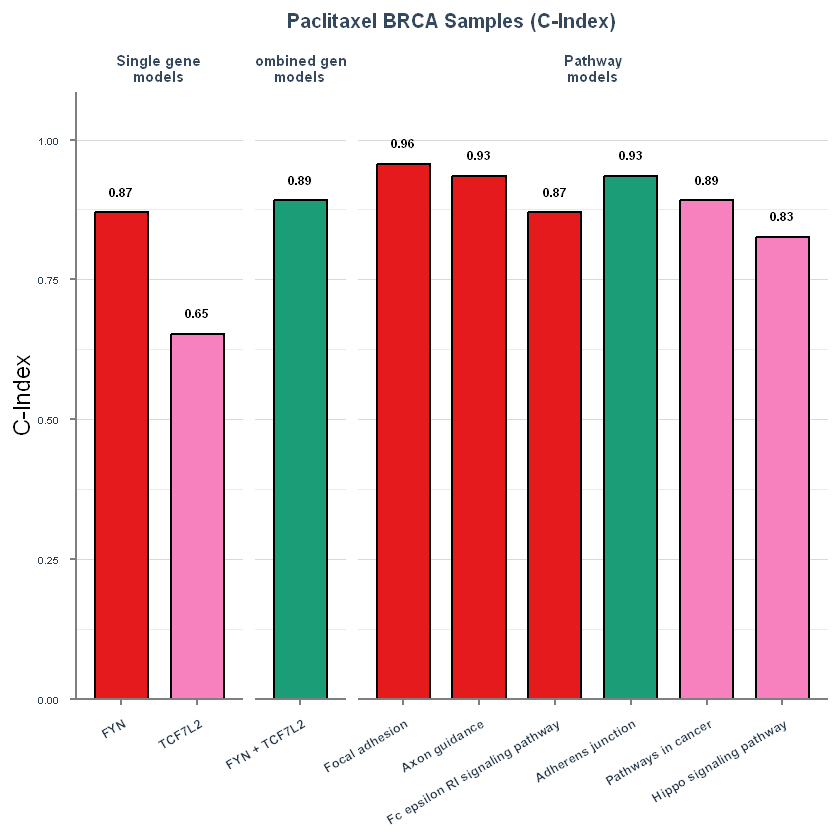

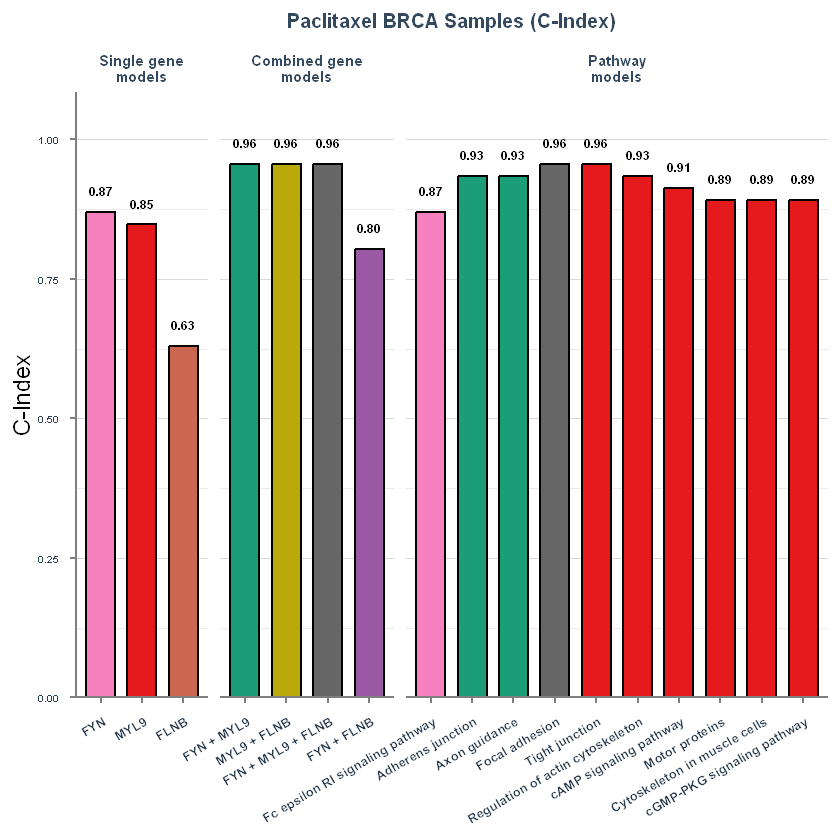

In [5]:
# Analyze and visualize results for specific genes
results_FYN_MYL9_FLNB_BRCA <- analyze_genes_and_pathways_for_models(
        gene_list = c("FYN", "MYL9", "FLNB"),
        excluded_pathways = c('Salmonella infection','Melanogenesis','Arrhythmogenic right ventricular cardiomyopathy','Basal cell carcinoma','Thyroid cancer','Acute myeloid leukemia','Hepatocellular carcinoma','Breast cancer','Gastric cancer','Cushing syndrome','Prostate cancer','Colorectal cancer','Endometrial cancer','Human papillomavirus infection','Viral myocarditis',"Pathogenic Escherichia coli infection", 'Salmonella infection', 'Viral myocarditis', 'Shigellosis', 'Phospholipase D signaling pathway', 'Natural killer cell mediated cytotoxicity','Oxytocin signaling pathway'),
        processed_data = CYTOi_Paclitaxel_BRCA,
        surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
        single_gene_model = CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel,
        multi_cox_model = multiGeneCox_CYTOi_BRCA,
        enrichment_table_path = "enriched_terms.xlsx",
        seed = 73
)

# Analyze and visualize results for specific genes
results_FYN_TCF7L2 <- analyze_genes_and_pathways_for_models(
        gene_list = c("FYN", "TCF7L2"),
        excluded_pathways = c('Wnt signaling pathway','Salmonella infection','Melanogenesis','Arrhythmogenic right ventricular cardiomyopathy','Basal cell carcinoma','Thyroid cancer','Acute myeloid leukemia','Hepatocellular carcinoma','Breast cancer','Gastric cancer','Cushing syndrome','Prostate cancer','Colorectal cancer','Endometrial cancer','Human papillomavirus infection','Viral myocarditis',"Pathogenic Escherichia coli infection", 'Salmonella infection', 'Viral myocarditis', 'Shigellosis', 'Phospholipase D signaling pathway', 'Natural killer cell mediated cytotoxicity','Oxytocin signaling pathway'),
        processed_data = CYTOi_Paclitaxel_BRCA,
        surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
        single_gene_model = CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel,
        multi_cox_model = multiGeneCox_CYTOi_BRCA,
        enrichment_table_path = "enriched_terms.xlsx",
        seed = 73
)

# Generate vertical barplot for the results
model1_results_1 = results_FYN_TCF7L2$Model1
plot_model1_FYN_TCF7L2 <- cindex_barplot_vertical_v5_improved(
        model1_results_1,
        "Model_1",
        'Paclitaxel BRCA Samples (C-Index)'
)
plot_model1_FYN_TCF7L2
# Generate vertical barplot for the results
model1_results = results_FYN_MYL9_FLNB_BRCA$Model1
plot_model1_FYN_MYL9_FLNB <- cindex_barplot_vertical_v5_improved(
  model1_results,
  "Model_1",
  'Paclitaxel BRCA Samples (C-Index)'
)
plot_model1_FYN_MYL9_FLNB
# Save the plot
#saveRDS(plot_model1_FYN_TCF7L2, 'Graphs/FYN_TCF7L2_CIndex.rds')


Processing genes for cna 
Filtered gene list for cna : LDHB, TCF7L2 
Calculating all intermediate combinations (combinations = 'all')...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


$CNA

$Mutation
NULL


Processing genes for cna 
Filtered gene list for cna : FYN, TCF7L2 
Calculating all intermediate combinations (combinations = 'all')...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


$CNA

$Mutation
NULL


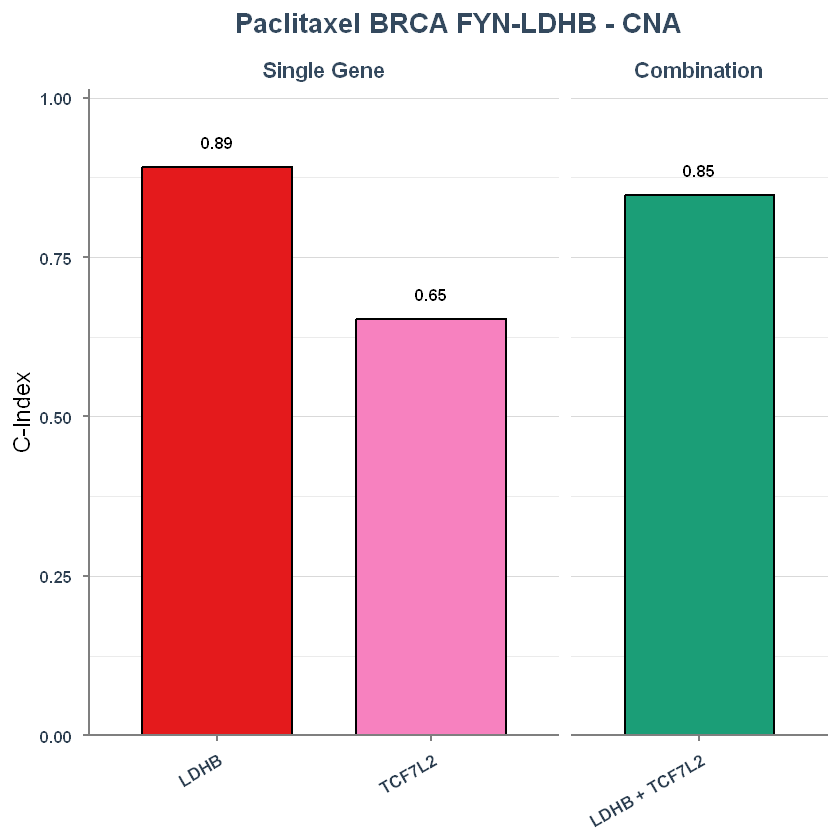

Processing genes for cna 
Filtered gene list for cna : FYN, CXCR4 
Calculating all intermediate combinations (combinations = 'all')...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


$CNA

$Mutation
NULL


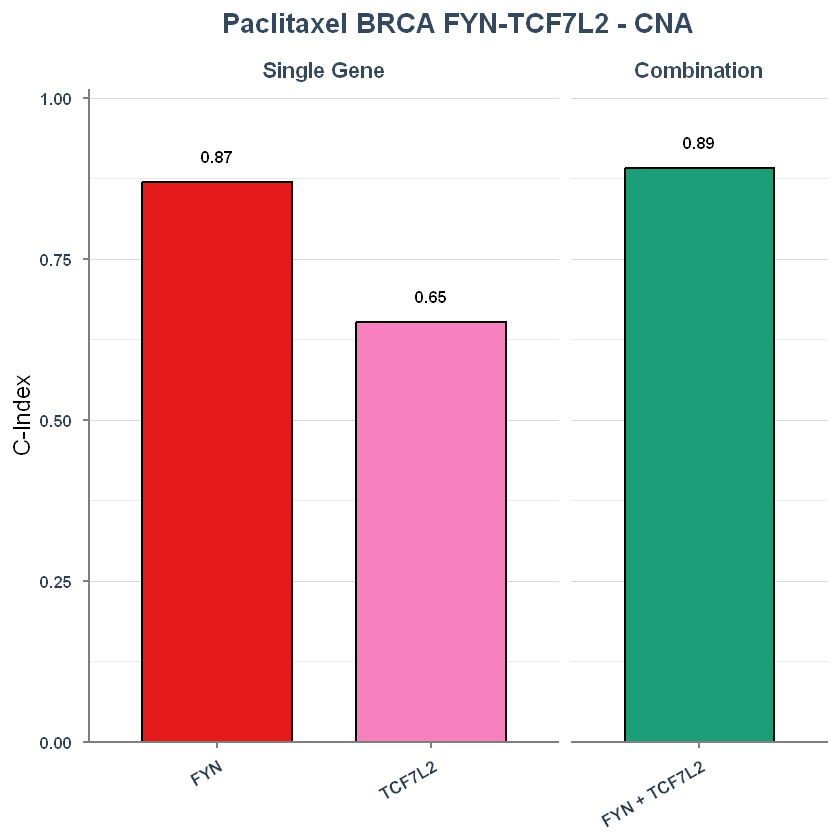

Processing genes for cna 
Filtered gene list for cna : CXCR4, FYN, TCF7L2 
Calculating only the full combination (combinations = 'singles_and_full')...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


$CNA

$Mutation
NULL


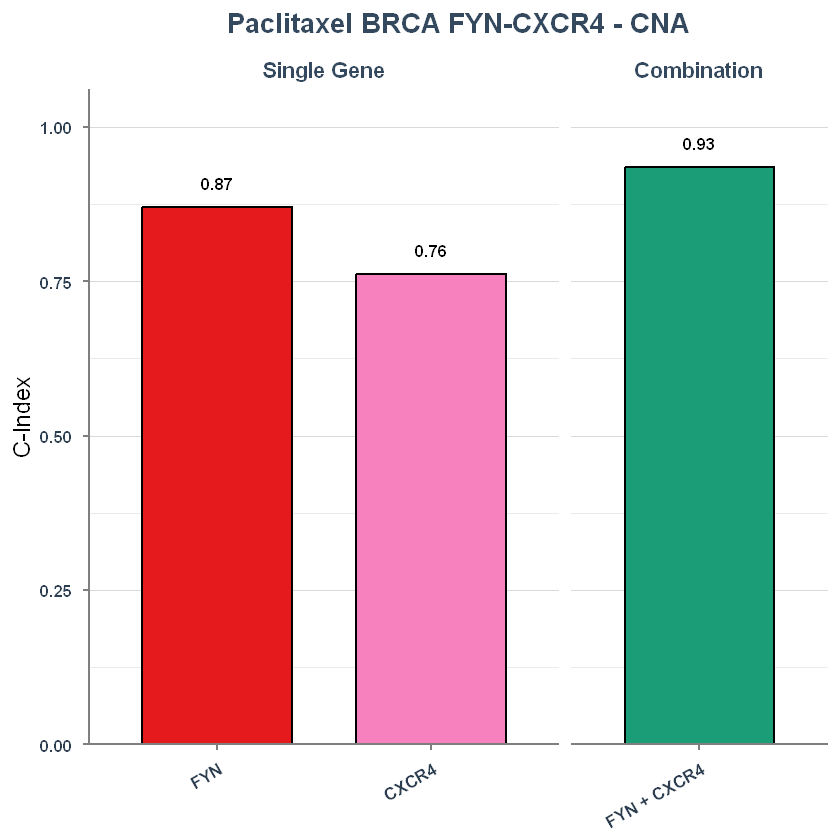

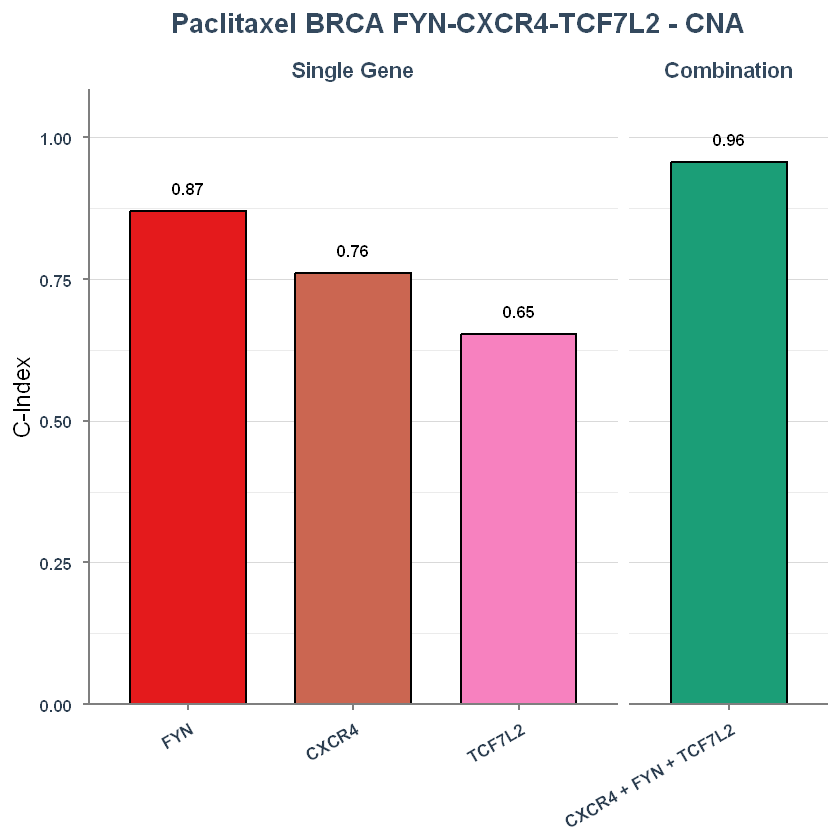

In [7]:
#---------------------------------------------------------------------------------------------------------------
# Additional Analysis for Gene Combinations and HRs

# Analyze combinations of specific genes
results_TCF_LDHB = analyze_genes_for_combinations(
        gene_list = c('LDHB', 'TCF7L2'),
        processed_data = CYTOi_Paclitaxel_BRCA,
        surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
        single_gene_model = CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel,
        seed = 73
)

# Plot results for gene combinations
results_TCF_LDHB_plot = plot_cindex_results_separate(
  results_TCF_LDHB,
        'Paclitaxel BRCA FYN-LDHB'
)
results_TCF_LDHB_plot
# Save CNA plot
#saveRDS(results_TCF_LDHB_plot$CNA, 'Graphs/LDHB_TCF7L2_BRCA_Cindex.rds')

#---

# Analyze combinations of specific genes
results_TCF_FYN = analyze_genes_for_combinations(
  gene_list = c('FYN', 'TCF7L2'),
  processed_data = CYTOi_Paclitaxel_BRCA,
  surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
  single_gene_model = CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel,
  seed = 73
)

# Plot results for gene combinations
results_TCF_FYN_plot = plot_cindex_results_separate(
  results_TCF_FYN,
  'Paclitaxel BRCA FYN-TCF7L2'
)
results_TCF_FYN_plot
# Save CNA plot
#saveRDS(results_TCF_FYN_plot$CNA, 'Graphs/FYN_TCF7L2_BRCA_Cindex.rds')

#-----

# Analyze combinations of specific genes
results_CXCR4_FYN = analyze_genes_for_combinations(
  gene_list = c('FYN', 'CXCR4'),
  processed_data = CYTOi_Paclitaxel_BRCA,
  surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
  single_gene_model = CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel,
  seed = 73
)

# Plot results for gene combinations
results_CXCR4_FYN_plot = plot_cindex_results_separate(
  results_CXCR4_FYN,
  'Paclitaxel BRCA FYN-CXCR4'
)
results_CXCR4_FYN_plot
# Save CNA plot
#saveRDS(results_CXCR4_FYN_plot$CNA, 'Graphs/FYN_CXCR4_BRCA_Cindex.rds')

#-------
# Analyze combinations of specific genes
results_CXCR4_FYN_TCF7L2_BRCA = analyze_genes_for_combinations(
  gene_list = c('CXCR4', 'FYN', 'TCF7L2'),
  processed_data = CYTOi_Paclitaxel_BRCA,
  surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
  single_gene_model = CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel,
  seed=73,
  combinations = 'singles_and_full'
  
)

# Plot results for gene combinations
results_CXCR4_FYN_TCF7L2_plot = plot_cindex_results_separate(
  results_CXCR4_FYN_TCF7L2_BRCA,
  'Paclitaxel BRCA FYN-CXCR4-TCF7L2'
)
results_CXCR4_FYN_TCF7L2_plot
# Save CNA plot
#saveRDS(results_CXCR4_FYN_TCF7L2_plot$CNA, 'Graphs/CXCR4_FYN_TCF7L2_Paclitaxel_BRCA_C_index.rds')


Processing single gene model for: LDHB 
Processing single gene model for: TCF7L2 
Calculating all intermediate combinations (combinations = 'all')...
Processing combination model for: LDHB + TCF7L2 


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


Processing single gene model for: FYN 
Processing single gene model for: TCF7L2 
Calculating all intermediate combinations (combinations = 'all')...
Processing combination model for: FYN + TCF7L2 


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


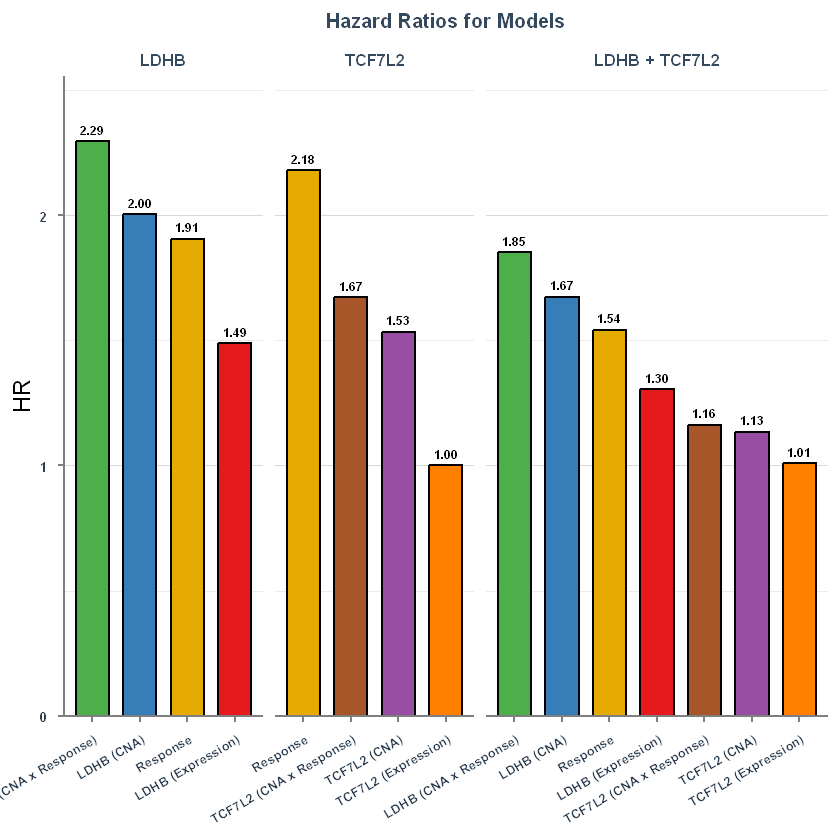

Processing single gene model for: FYN 
Processing single gene model for: CXCR4 
Calculating all intermediate combinations (combinations = 'all')...
Processing combination model for: FYN + CXCR4 


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


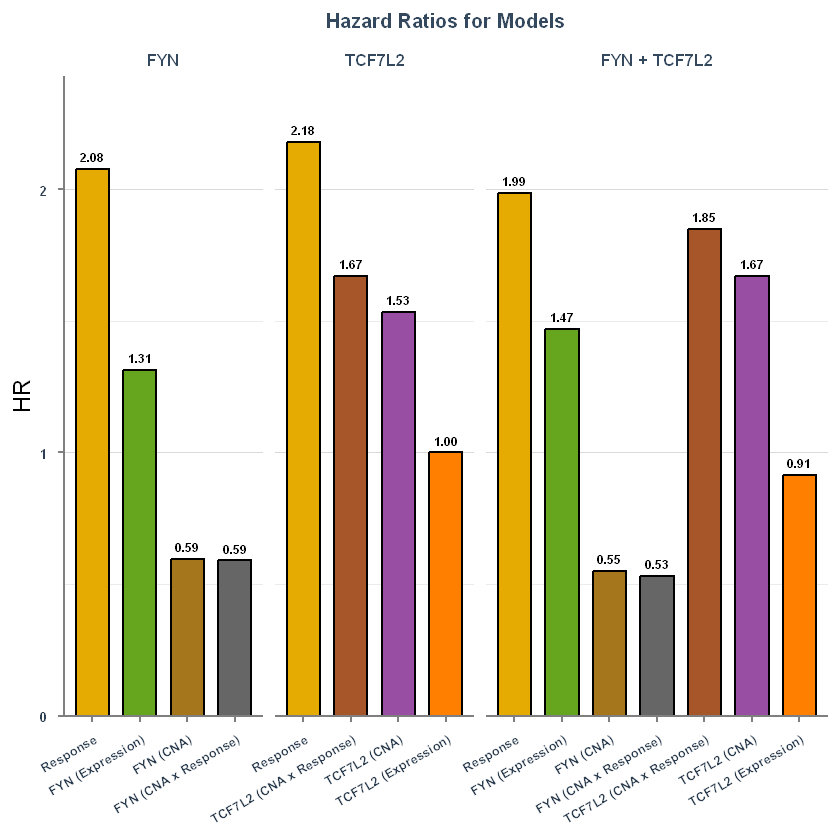

Processing single gene model for: FYN 
Processing single gene model for: CXCR4 
Processing single gene model for: TCF7L2 
Calculating only the full combination (combinations = 'singles_and_full')...
Processing full combination model for: FYN + CXCR4 + TCF7L2 


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


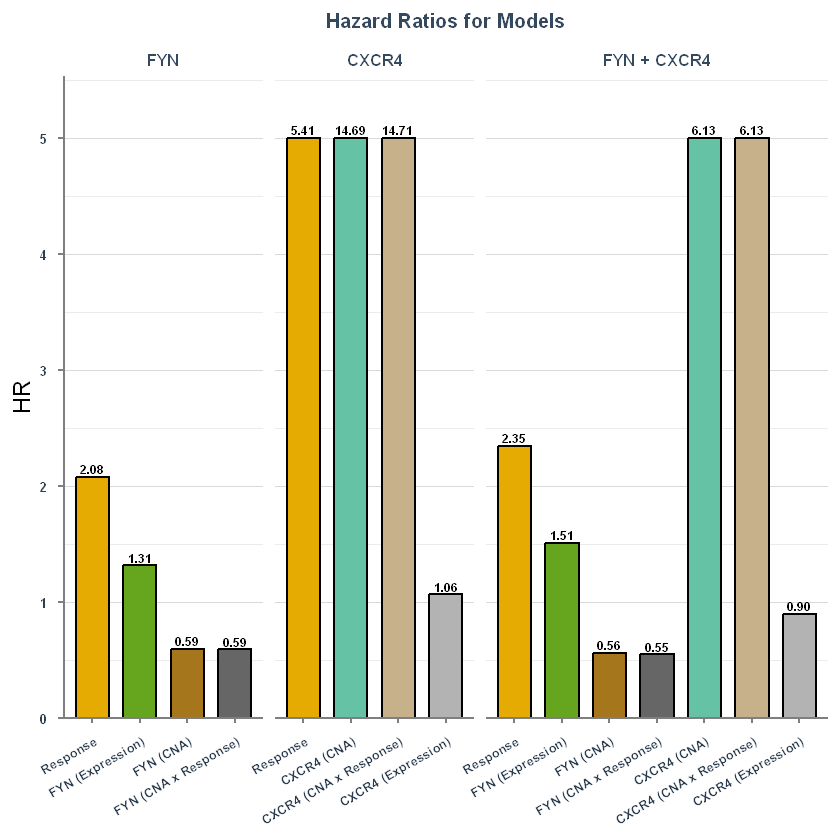

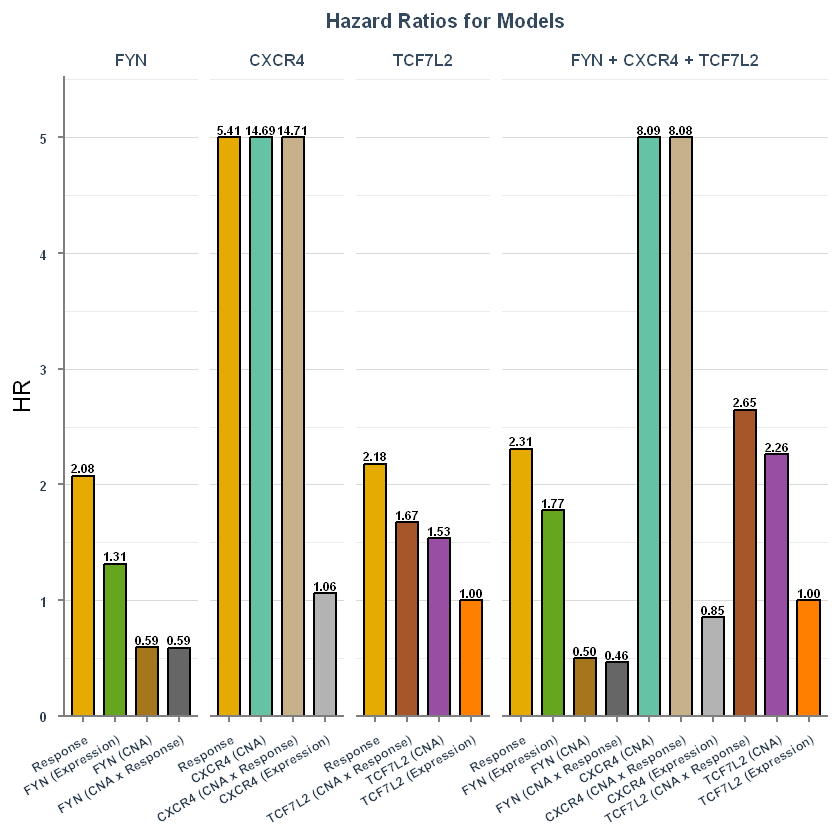

In [8]:
#---------------------------------------------------------------------------------------------------------------
# Hazard Ratio Analysis

# Perform HR analysis for specific genes
A = analyze_genes_with_hr(
        gene_list = c('LDHB', 'TCF7L2'),
        processed_data = CYTOi_Paclitaxel_BRCA,
        surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
        seed = 73
)

# Format terms for visualization
A$Term = format_terms(A$Term)

# Plot HR bar chart
LDHB_TCF_HR = plot_hr_bar(A)
LDHB_TCF_HR
# Save HR bar chart
#saveRDS(LDHB_TCF_HR, 'Graphs/LDHB_TCF7L2_HR_BRCA.rds')

#-----

# Perform HR analysis for specific genes
A = analyze_genes_with_hr(
  gene_list = c('FYN', 'TCF7L2'),
  processed_data = CYTOi_Paclitaxel_BRCA,
  surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
  seed = 73
)

# Format terms for visualization
A$Term = format_terms(A$Term)

# Plot HR bar chart
FYN_TCF_HR = plot_hr_bar(A)
FYN_TCF_HR
# Save HR bar chart
#saveRDS(FYN_TCF_HR, 'Graphs/FYN_TCF7L2_HR_BRCA.rds')

#------

# Perform HR analysis for specific genes
A = analyze_genes_with_hr(
  gene_list = c('FYN', 'CXCR4'),
  processed_data = CYTOi_Paclitaxel_BRCA,
  surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
  seed = 73
)

# Format terms for visualization
A$Term = format_terms(A$Term)

# Plot HR bar chart
FYN_CXCR4_HR = plot_hr_bar(A)
FYN_CXCR4_HR
# Save HR bar chart
#saveRDS(FYN_CXCR4_HR, 'Graphs/FYN_CXCR4_HR_BRCA.rds')

#----------

# Perform HR analysis for specific genes
A = analyze_genes_with_hr(
  gene_list = c('FYN', 'CXCR4', 'TCF7L2'),
  processed_data = CYTOi_Paclitaxel_BRCA,
  surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
  seed=73,
  combinations = 'singles_and_full'
)

# Format terms for visualization
A$Term = format_terms(A$Term)

# Plot HR bar chart
FYN_CXCR4_TCF7L2_HR_BRCA = plot_hr_bar(A)

FYN_CXCR4_TCF7L2_HR_BRCA
# Save HR bar chart
#saveRDS(FYN_CXCR4_TCF7L2_HR_BRCA, 'Graphs/FYN_CXCR4_TCF7L2_BRCA_HR.rds')


#------



In [3]:
#synergistic pen cox models------------------------------

rename_generic_terms <- function(term_vec, GEN1, GEN2) {
  out <- term_vec
  # gene1
  out <- gsub(paste0("expr_", GEN1), "expr_gene1", out, fixed = TRUE)
  out <- gsub(paste0("factor(cna_", GEN1, ")1"), "factor(cna_gene1)1", out, fixed = TRUE)
  # gene2
  out <- gsub(paste0("expr_", GEN2), "expr_gene2", out, fixed = TRUE)
  out <- gsub(paste0("factor(cna_", GEN2, ")1"), "factor(cna_gene2)1", out, fixed = TRUE)
  out
}

rename_pretty_generic_terms <- function(term_vec_generic) {
  x <- term_vec_generic
  
  x <- gsub("^factor\\(condition\\)([^:]+)$",                  "HR CONDITION[\\1]", x)
  x <- gsub("^factor\\(cna_gene1\\)1:factor\\(condition\\)([^:]+)$",
            "HR CNA_GENE1 : CONDITION[\\1]", x)
  x <- gsub("^factor\\(cna_gene2\\)1:factor\\(condition\\)([^:]+)$",
            "HR CNA_GENE2 : CONDITION[\\1]", x)
  
  #main 
  x <- gsub("^expr_gene1$",                "HR EXP_GENE1", x)
  x <- gsub("^expr_gene2$",                "HR EXP_GENE2", x)
  x <- gsub("^factor\\(cna_gene1\\)1$",    "HR CNA_GENE1", x)
  x <- gsub("^factor\\(cna_gene2\\)1$",    "HR CNA_GENE2", x)
  
  # twoways interaction
  x <- gsub("^expr_gene1:expr_gene2$",                       "HR EXP_GENE1 : EXP_GENE2", x)
  x <- gsub("^expr_gene1:factor\\(cna_gene2\\)1$",           "HR EXP_GENE1 : CNA_GENE2", x)
  x <- gsub("^factor\\(cna_gene1\\)1:expr_gene2$",           "HR CNA_GENE1 : EXP_GENE2", x)
  x <- gsub("^factor\\(cna_gene1\\)1:factor\\(cna_gene2\\)1$","HR CNA_GENE1 : CNA_GENE2", x)
  x
}

# wide + generic + pretty 
two_way_glmnet_wide_generic_pretty <- function(
    GEN1, GEN2,
    data,                        
    surv,                       
    dataset_label   = "BRCA",
    treatment_label = "Paclitaxel",
    alpha = 0,
    seed  = 73
){
  
  two_way_formula_str <- paste(
    "~ (",
    paste0("expr_", GEN1), "+", paste0("factor(cna_", GEN1, ")"),
    ") * (",
    paste0("expr_", GEN2), "+", paste0("factor(cna_", GEN2, ")"),
    ")",
    "+",
    "factor(condition)",
    "+",
    paste0("factor(cna_", GEN1, ")"), ":factor(condition)",
    "+",
    paste0("factor(cna_", GEN2, ")"), ":factor(condition)"
  )
  

  mm <- model.matrix(as.formula(two_way_formula_str), data = data)
  if ("(Intercept)" %in% colnames(mm)) mm <- mm[, -1, drop = FALSE]
  
  # CV-glmnet (cox)
  set.seed(seed)
  cv_fit <- cv.glmnet(mm, surv, family = "cox", alpha = alpha)
  best_lambda <- cv_fit$lambda.min
  
  # Coef & HR
  coef_mat <- as.matrix(coef(cv_fit, s = "lambda.min"))
  coef_df <- tibble(
    Term         = rownames(coef_mat),
    Coefficient  = as.numeric(coef_mat[, 1]),
    Hazard_Ratio = exp(Coefficient)
  )
  
  # C-index
  risk <- predict(cv_fit, newx = mm, s = best_lambda, type = "link")
  cindex <- tryCatch({
    concordance.index(x = as.numeric(risk), surv.time = surv[,1], surv.event = surv[,2])$c.index
  }, error = function(e) NA_real_)
  
 
  coef_df$Term_generic <- rename_generic_terms(coef_df$Term, GEN1, GEN2)
  coef_df$Term_pretty  <- rename_pretty_generic_terms(coef_df$Term_generic)
  
  # Wide
  wide_tbl <- coef_df %>%
    select(Term_pretty, Hazard_Ratio) %>%
    tidyr::pivot_wider(names_from = Term_pretty, values_from = Hazard_Ratio)
  
  # Meta
  wide_tbl <- wide_tbl %>%
    mutate(
      Dataset   = dataset_label,
      Treatment = treatment_label,
      Gene_Pair = paste(GEN1, "+", GEN2),
      C_Index   = round(cindex, 3),
      Lambda    = best_lambda,
      .before = 1
    )
  
  list(
    summary_wide_pretty = wide_tbl,
    coefficients_long   = coef_df,
    model               = cv_fit,
    lambda_min          = best_lambda
  )
}

out1 <- two_way_glmnet_wide_generic_pretty(
 GEN1 = "TCF7L2", GEN2 = "LDHB",
 data = CYTOi_Paclitaxel_BRCA,
 surv = CYTOi_BRCA_Paclitaxel_Surv
)
out2 <- two_way_glmnet_wide_generic_pretty(
 GEN1 = "TCF7L2", GEN2 = "FYN",
 data = CYTOi_Paclitaxel_BRCA,
 surv = CYTOi_BRCA_Paclitaxel_Surv
)
out3 <- two_way_glmnet_wide_generic_pretty(
 GEN1 = "FYN", GEN2 = "CXCR4",
 data = CYTOi_Paclitaxel_BRCA,
 surv = CYTOi_BRCA_Paclitaxel_Surv
)

combined_results <- bind_rows(out1$summary_wide_pretty, out2$summary_wide_pretty, out3$summary_wide_pretty)
combined_results


Dataset,Treatment,Gene_Pair,C_Index,Lambda,HR EXP_GENE1,HR CNA_GENE1,HR EXP_GENE2,HR CNA_GENE2,HR CONDITION[sensitive],HR EXP_GENE1 : EXP_GENE2,HR EXP_GENE1 : CNA_GENE2,HR CNA_GENE1 : EXP_GENE2,HR CNA_GENE1 : CNA_GENE2,HR CNA_GENE1 : CONDITION[sensitive],HR CNA_GENE2 : CONDITION[sensitive]
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BRCA,Paclitaxel,TCF7L2 + LDHB,0.848,0.2059526,0.9894953,1.0556990,1.2214144,1.3191864,1.414882,1.004210,1.0363241,1.0053042,1.8384782,1.0665240,1.3922975
BRCA,Paclitaxel,TCF7L2 + FYN,0.891,0.1209628,0.9403425,1.4118459,1.3274081,0.6923251,1.743791,1.002431,0.9437122,1.0791471,0.5378607,1.5088709,0.6858213
BRCA,Paclitaxel,FYN + CXCR4,0.935,0.1134970,1.3269204,0.7037608,0.9420673,3.4452204,1.826893,1.001284,1.1621142,0.9428143,1.0004836,0.7008326,3.4445005


In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Kaplan-Meier Survival Analysis

# Perform Kaplan-Meier analysis for filtered models
results3 <- kaplan_meier_analysis(
  model1_data = CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel$Model_1,
  model2_data = CYTOi_EMC_BRCA_Paclitaxel_Pen_CoxModel$Model_2,
  surv_obj = CYTOi_BRCA_Paclitaxel_Surv,
  processed_data = CYTOi_Paclitaxel_BRCA,
  hr_threshold = 1.1,
  plot = F,
  seed = 73,
  th_pval = 0.05,
  plot_title_prefix = 'Paclitaxel BRCA Samples'
)


MYL9_KM_BRCA = results3$Model1$Plots$MYL9_Interaction_cna_condition_HR
SDC4_KM_BRCA = results3$Model1$Plots$SDC4_Interaction_cna_condition_HR
SULF2_KM_BRCA = results3$Model1$Plots$SULF2_Interaction_cna_condition_HR
CXCR4_KM_BRCA = results3$Model1$Plots$CXCR4_Interaction_cna_condition_HR
CXCR4_KM_CNA_BRCA = results3$Model1$Plots$CXCR4_CNA_HR

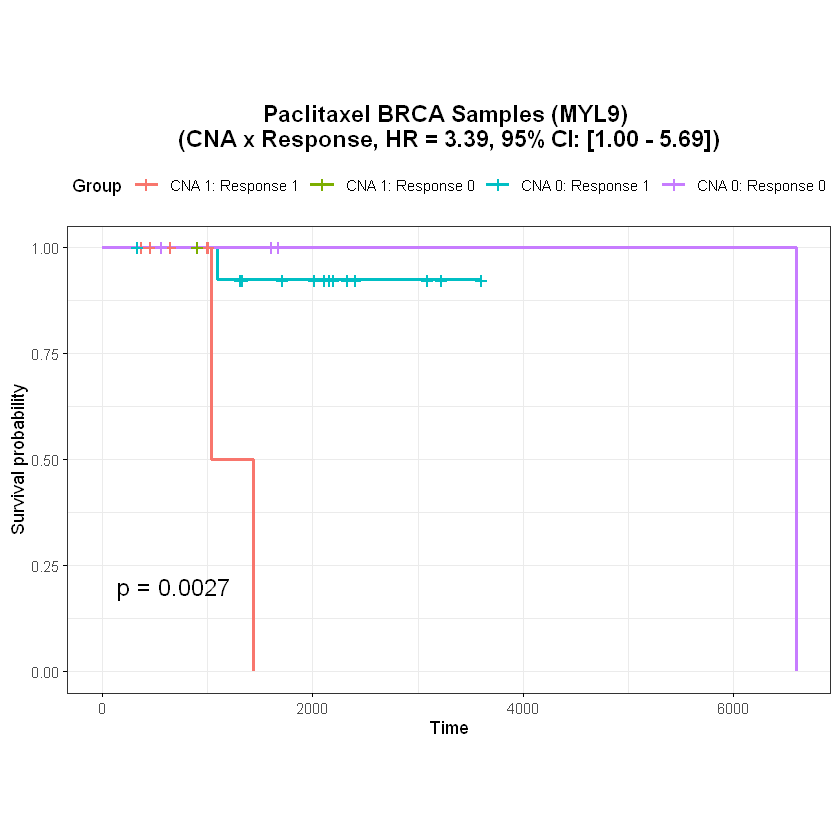

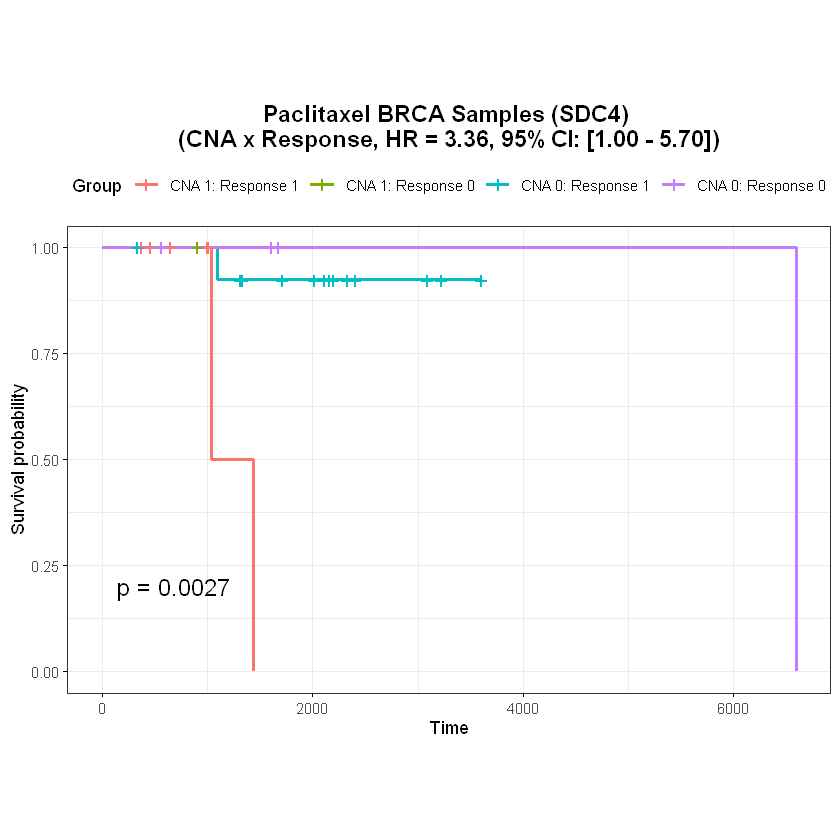

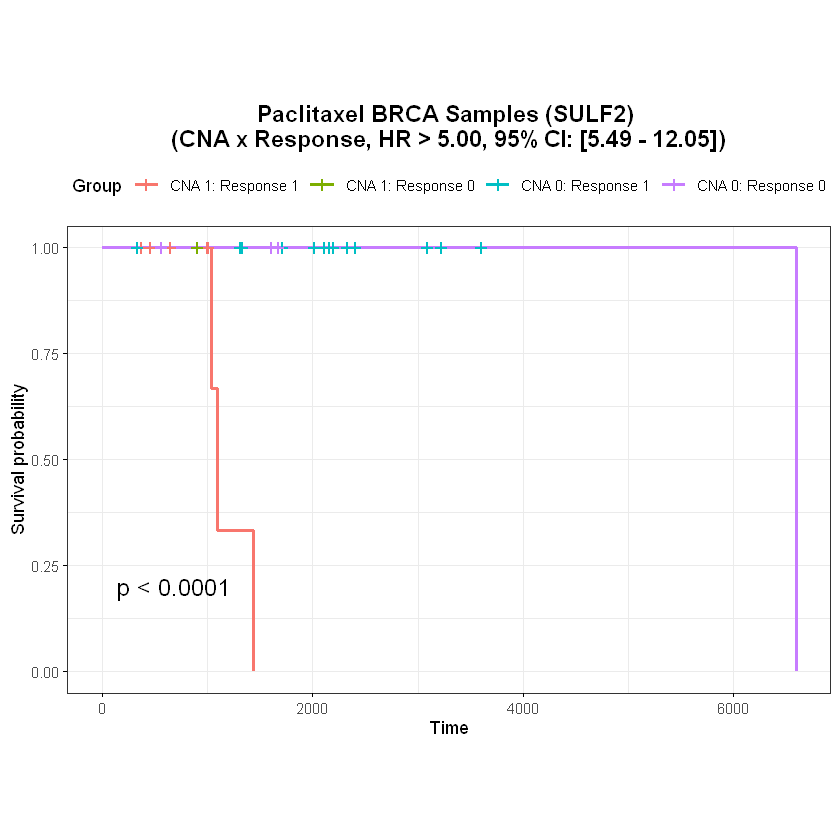

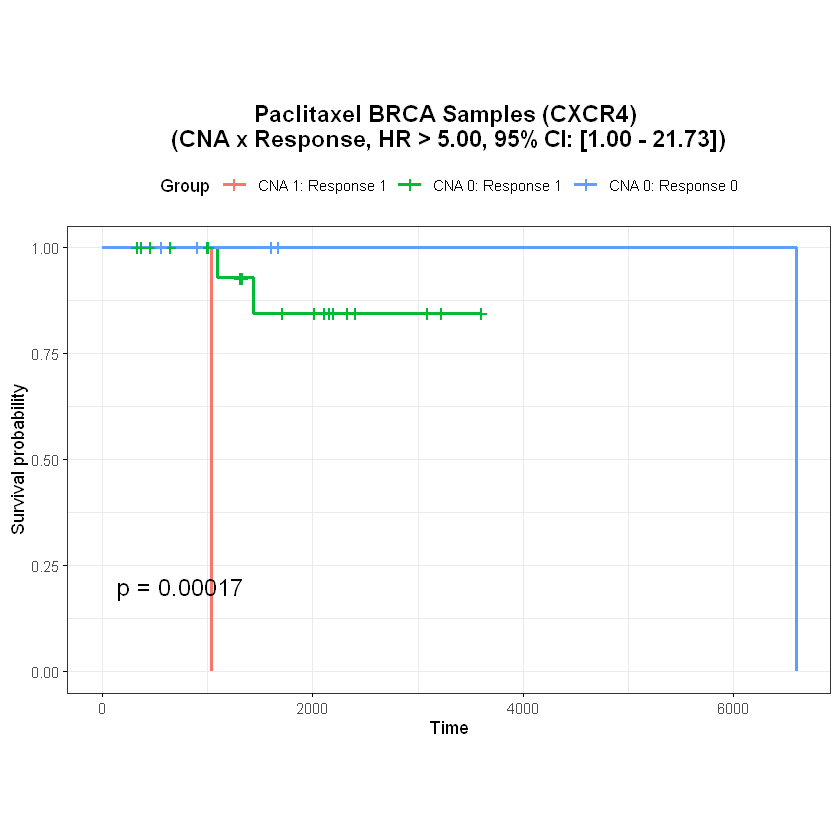

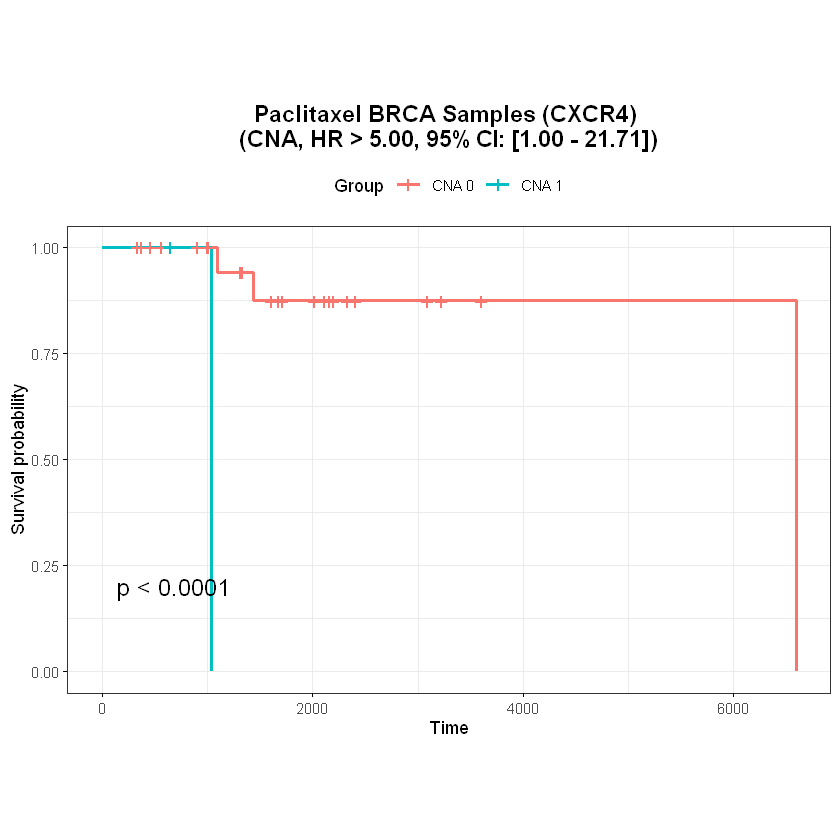

In [10]:
MYL9_KM_BRCA
SDC4_KM_BRCA
SULF2_KM_BRCA
CXCR4_KM_BRCA
CXCR4_KM_CNA_BRCA